In [ ]:
# code to cluster energy deposit into event (pre-culstering in this case - see readme file)

In [1]:
# Upload h5 file

In [64]:
%run ../../Initialisation_Notebook/Initialize.ipynb

Initialization done, Notebook was last run on: 15/04/2020 at 13:22:08


In [3]:
def move_xyz_to_cm(sim):
    sim['z_mean']=(sim.z_mean.values-500)/10
    sim['x_mean']=(sim.x_mean.values)/10
    sim['y_mean']=(sim.y_mean.values)/10
    return sim

def maxDiff(arr, arr_size): 
    max_diff = arr[1] - arr[0] 
      
    for i in range( 0, arr_size ): 
        for j in range( i+1, arr_size ): 
            if(arr[j] - arr[i] > max_diff):  
                max_diff = arr[j] - arr[i] 
      
    return max_diff 

In [4]:
df_0vbb = pd.read_hdf('0vbb_simulation_uniform_all_tpc.h5', key='df')

In [5]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

import nestpy 
#Detector identification
detector = nestpy.DetectorExample_XENON10()
# detector = nestpy.VDetector()

# Performing NEST calculations according to the given detector example       
nc = nestpy.NESTcalc(detector) #can also be left empty    
#GetInteractionObject grabs the number for the interaction you want so you don't have to always reference the dictionary. Just type e.g., 'ion'
#It just changes the name to a number for nestpy to do its work.
def GetInteractionObject(name):
    name = name.lower()
    
    if name == 'er':
        raise ValueError("For 'er', specify either 'gammaray' or 'beta'")
    
    nest_interaction_number = dict(
        nr=0,
        wimp=1,
        b8=2,
        dd=3,
        ambe=4,
        cf=5,
        ion=6,
        gammaray=7,
        beta=8,
        ch3t=9,
        c14=10,
        kr83m=11,
        nonetype=12,
    )
    
    interaction_object = nestpy.INTERACTION_TYPE(nest_interaction_number[name])
    return interaction_object



In [6]:
from mpl_toolkits.mplot3d import Axes3D

In [67]:
def PreClustering(test, dir_to_plot, eps_clustering, testing=False):
    
    %mkdir $dir_to_plot
    list_result=[]
    pd.set_option('mode.chained_assignment', None)
    interaction_object=GetInteractionObject('beta')

    for eID in test.eventID.unique():
        event=test[test.eventID==eID]

        # CLUSTERING - Saved XYZ as array
        zr_tot=[]
        for i in range(len(event)):
            zr_tot.append(event.xDep.values[i])
            zr_tot.append(event.yDep.values[i])
            zr_tot.append(event.zDep.values[i])

        zr_tot= np.asarray(zr_tot).reshape(len(event),3)  

        # Used DB scan : Step Limiter = 5mum -> esp = 5 mm ?  
        db = DBSCAN(eps=eps_clustering, min_samples=1).fit(zr_tot)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print_e=[1,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9999]
        for i in range(len(print_e)):
            if eID==print_e[i]:
                print('Event', eID)
                print('...Estimated number of clusters: %d' % n_clusters_)
                print('...Estimated number of noise points: %d' % n_noise_)

        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        fig = plt.figure()
        ax = Axes3D(fig)
        for k, col in zip(unique_labels, colors):
            
            
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)
            #point in cluster nb #k

            xy = zr_tot[class_member_mask & core_samples_mask]
            event['cluster_%0.i'%(k)]=(class_member_mask & core_samples_mask)
           
            # calcul energie dans la trace 
            e_cluster_array=[]
  
            e_tot_track=np.sum(event[event['cluster_%0.i'%(k)]].edep)*1000 
           
            e_to_feed_to_nest = e_tot_track
            e_cluster_array.append(e_to_feed_to_nest)
            nest_calculation = nc.GetYields(interaction = interaction_object, 
                                                    energy=e_to_feed_to_nest, drift_field = 81)
            getquanta= nc.GetQuanta(nest_calculation,2.862)
            el=getquanta.photons
            p=getquanta.electrons
            nel=el
            nph=p
            
            list_result.append([np.average(event[event['cluster_%0.i'%(k)]].xDep.values, 
                                           weights=event[event['cluster_%0.i'%(k)]]["edep"]),
                                np.average(event[event['cluster_%0.i'%(k)]].yDep.values, 
                                           weights=event[event['cluster_%0.i'%(k)]]["edep"]),
                                np.average(event[event['cluster_%0.i'%(k)]].zDep.values, 
                                           weights=event[event['cluster_%0.i'%(k)]]["edep"]),
                                max(event[event['cluster_%0.i'%(k)]].xDep.values)-min(event[event['cluster_%0.i'%(k)]].xDep.values),
                                max(event[event['cluster_%0.i'%(k)]].yDep.values)-min(event[event['cluster_%0.i'%(k)]].yDep.values),
                                max(event[event['cluster_%0.i'%(k)]].zDep.values)-min(event[event['cluster_%0.i'%(k)]].zDep.values),
                                e_tot_track,e_cluster_array,nph,nel, eID,n_clusters_,k])

            
            if testing ==False :
                if eID<20:
                    ax.scatter(xy[:, 0], xy[:, 1],xy[:, 2], c=col, s=10)

                    if k== 0 :
                        colorhere='b'
                    elif k==1 :
                        colorhere ='r'
                    # point that are not found in a cluster
                    xy = zr_tot[class_member_mask & ~core_samples_mask]
                    ax.scatter(xy[:, 0], xy[:, 1],xy[:, 2], 'o', c=col,s=10)
        
        if testing ==False :
            if eID<20:
                plt.tight_layout()

                #plt.rcParams['ztick.labelsize'] = 16

                ax.set_xlabel('x (mm)', fontsize=16)#,linespacing=10)
                ax.set_ylabel('y (mm)', fontsize=16)#, linespacing=10)
                ax.set_zlabel('Z (mm)', fontsize=16)#, linespacing=10)
                #ax.dist = 2

                plt.rcParams['axes.labelpad'] = 20


                plt.title('Estimated number of clusters: %d'%(n_clusters_,), fontsize=12)
                plt.savefig(dir_to_plot+'/event_nb_%i.png'%(eID))
                plt.show()
            else :
                plt.close()
        else :
            
            plt.tight_layout()

            #plt.rcParams['ztick.labelsize'] = 16

            ax.set_xlabel('x (mm)', fontsize=16)#,linespacing=10)
            ax.set_ylabel('y (mm)', fontsize=16)#, linespacing=10)
            ax.set_zlabel('Z (mm)', fontsize=16)#, linespacing=10)
            #ax.dist = 2

            plt.rcParams['axes.labelpad'] = 20


            plt.title('Estimated number of clusters: %d'%(n_clusters_,), fontsize=12)
            plt.savefig(dir_to_plot+'/event_nb_%i.png'%(eID))
            
            plt.show()

            print(list_result[0][6])
            

    df_cluster =pd.DataFrame(list_result,columns=["x_mean", "y_mean","z_mean", 
                                                  "delta_x_track","delta_y_track","delta_z_track",
                                                  "etot","e_cluster_array","nph","nel",
                                                  "event_id","nb_cluster", "cluster_id", 
                                                  ])
    
    return df_cluster

mkdir: 0vbb_PreClustering_plot_10mum: File exists


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

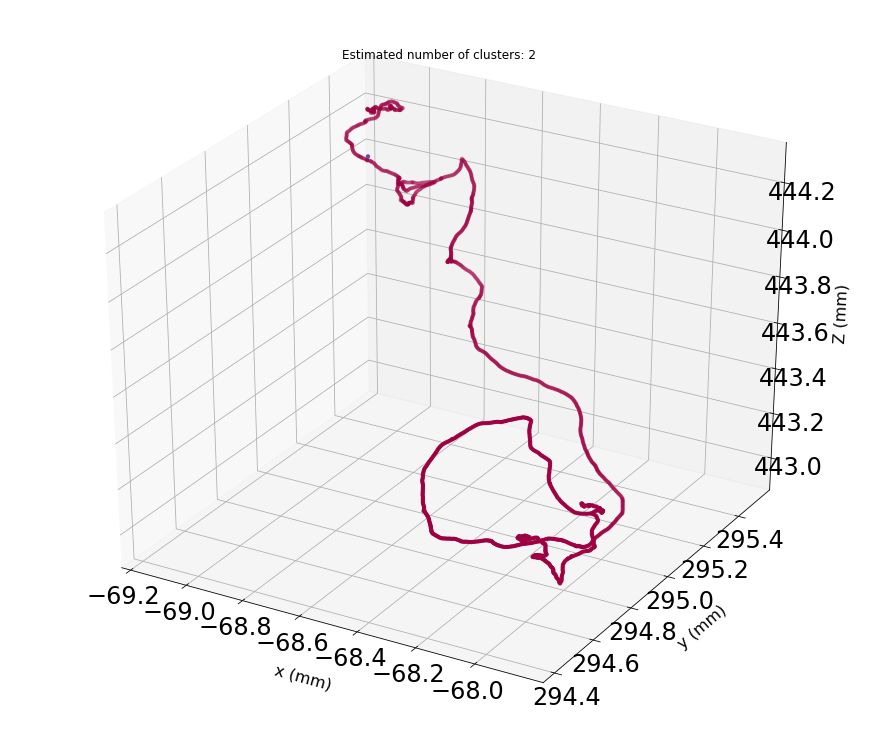

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Event 1
...Estimated number of clusters: 5
...Estimated number of noise points: 0


/Users/therreau/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


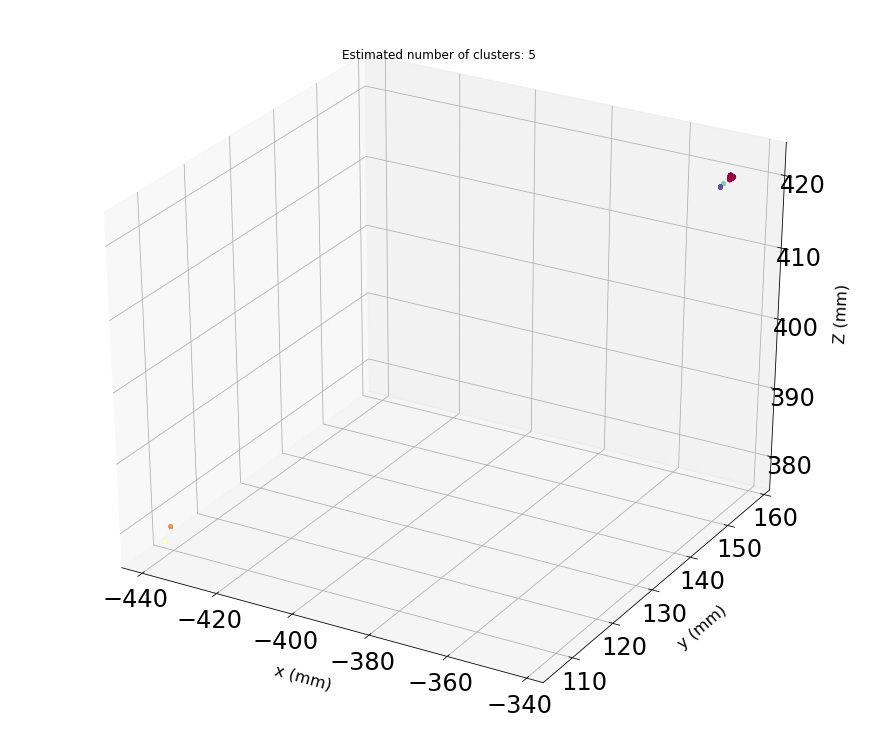

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

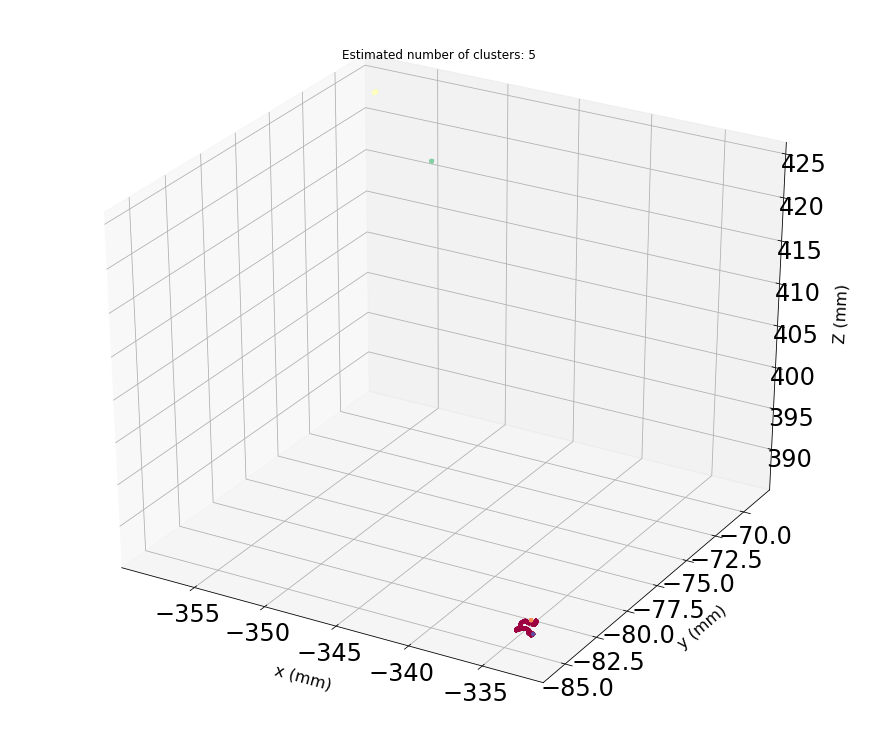

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/therreau/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


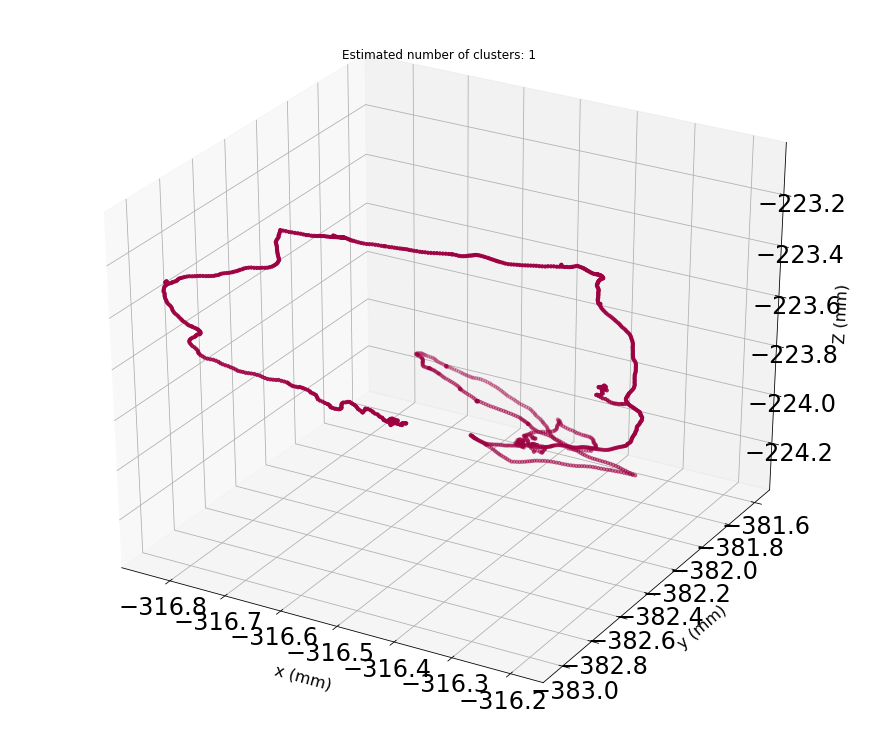

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

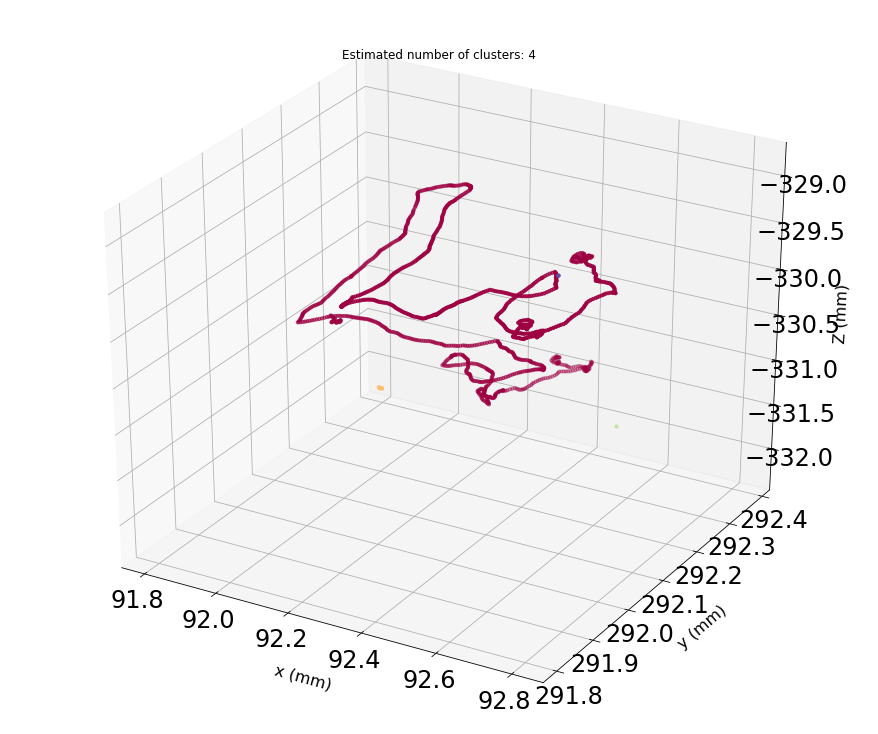

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

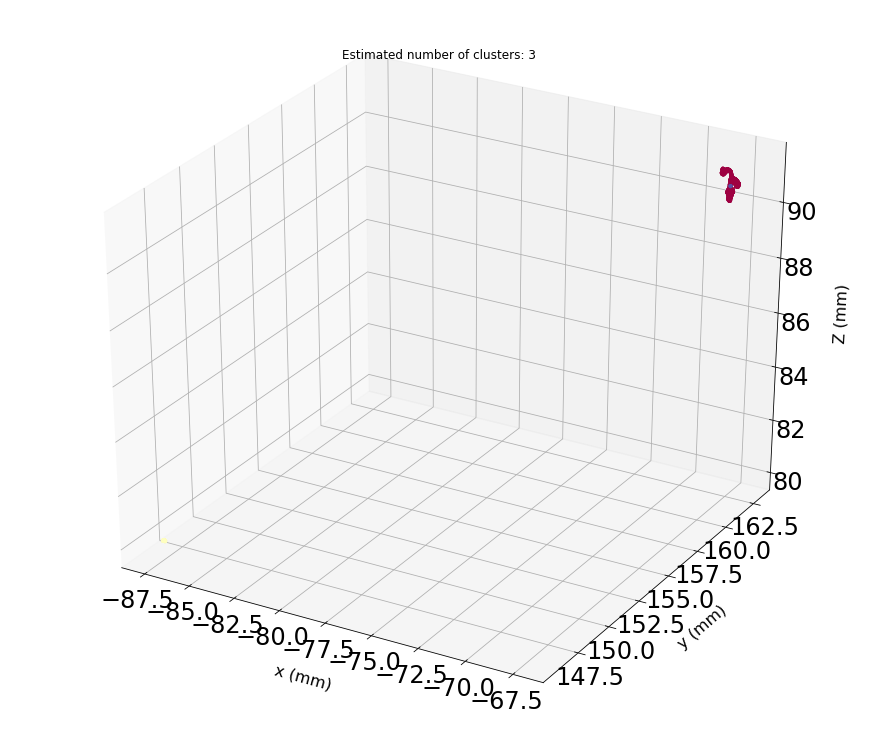

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

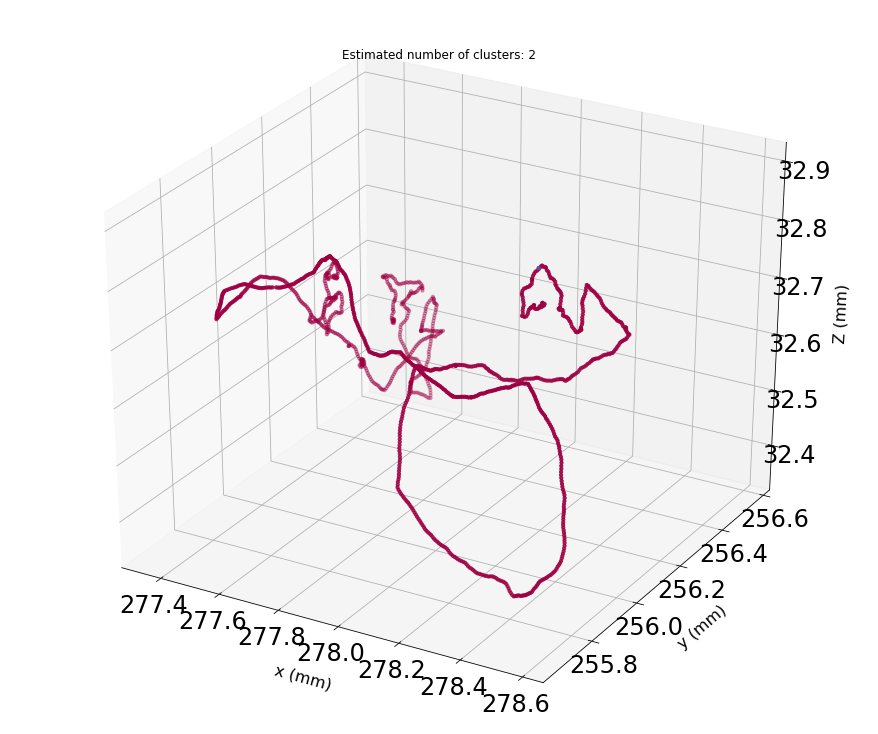

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

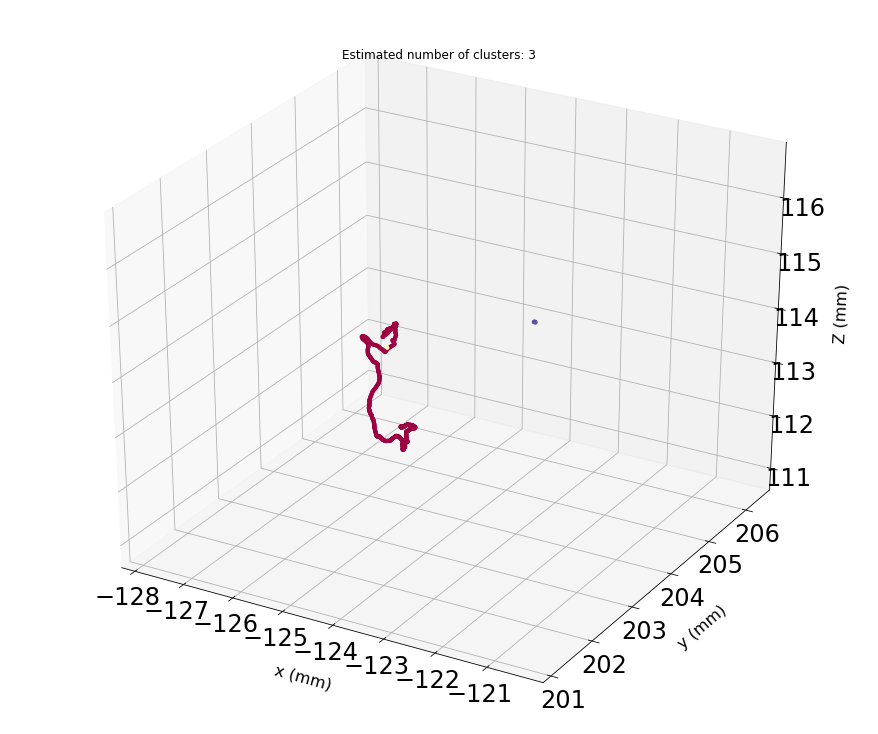

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

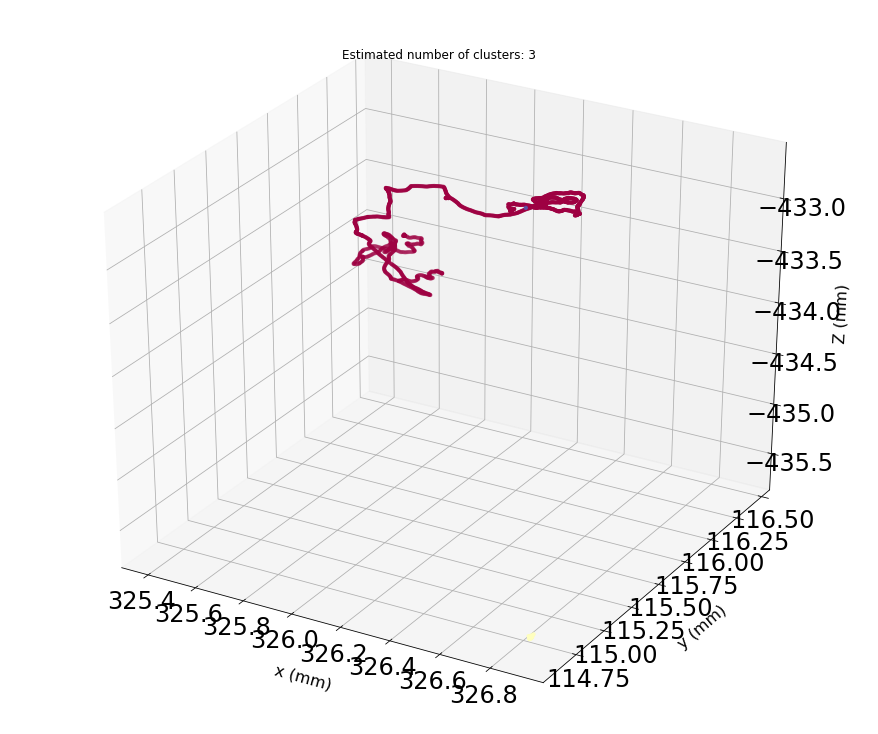

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

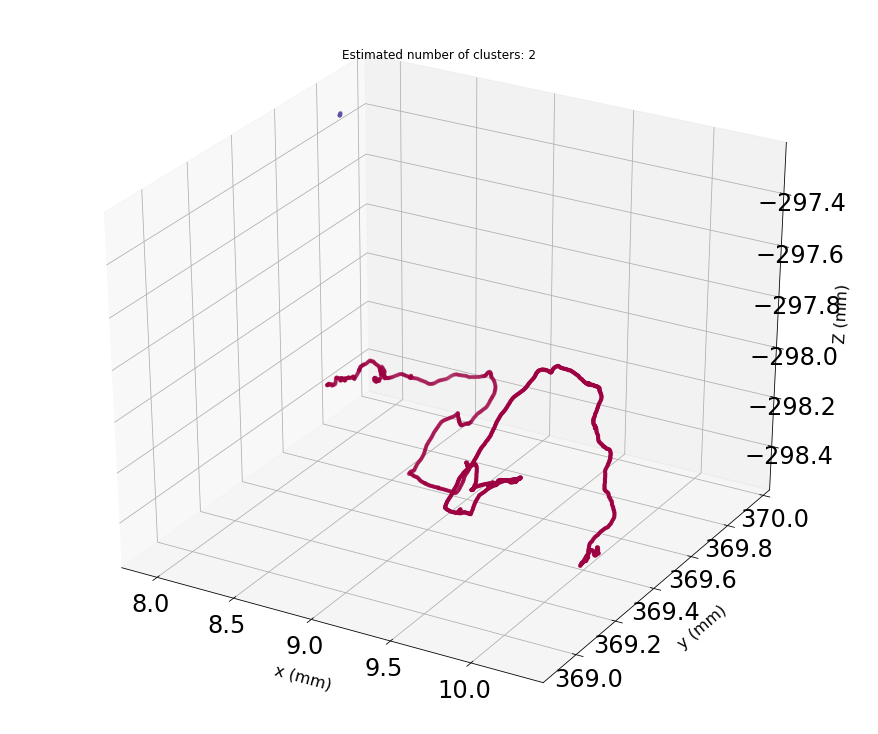

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

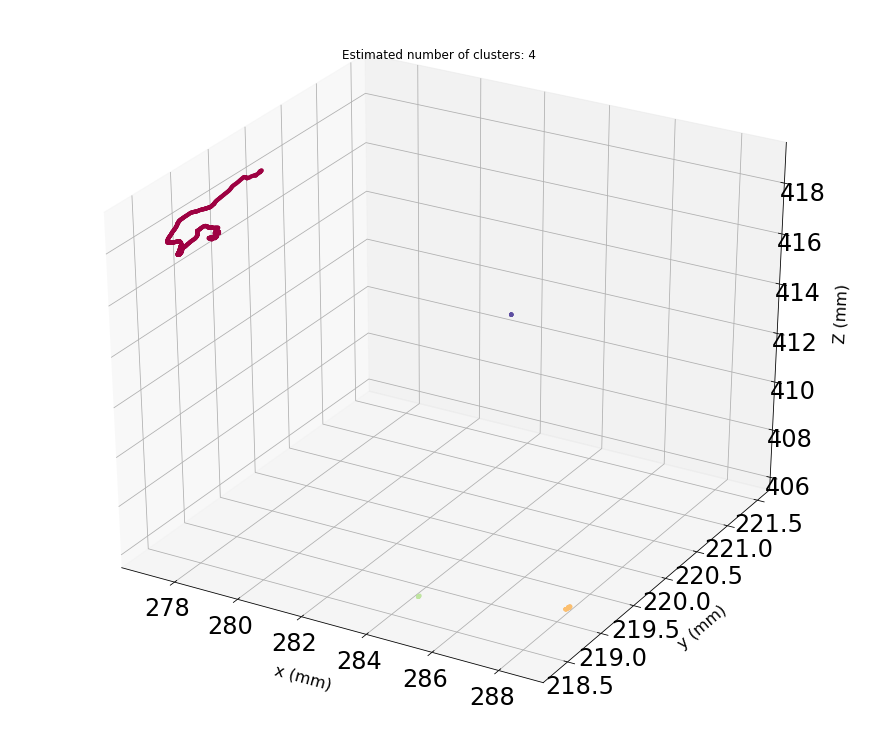

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/therreau/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


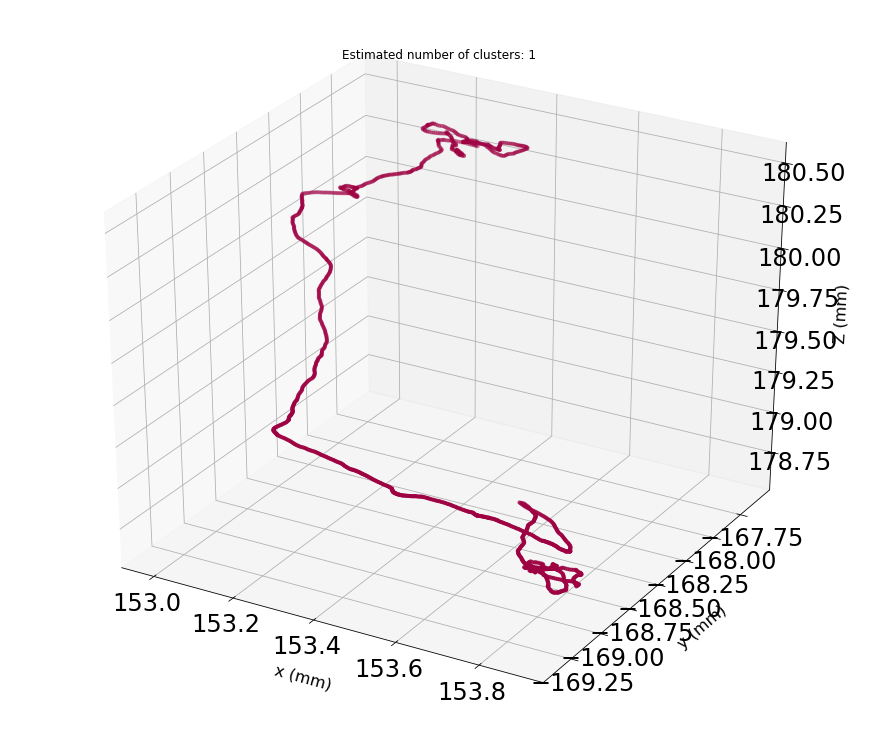

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

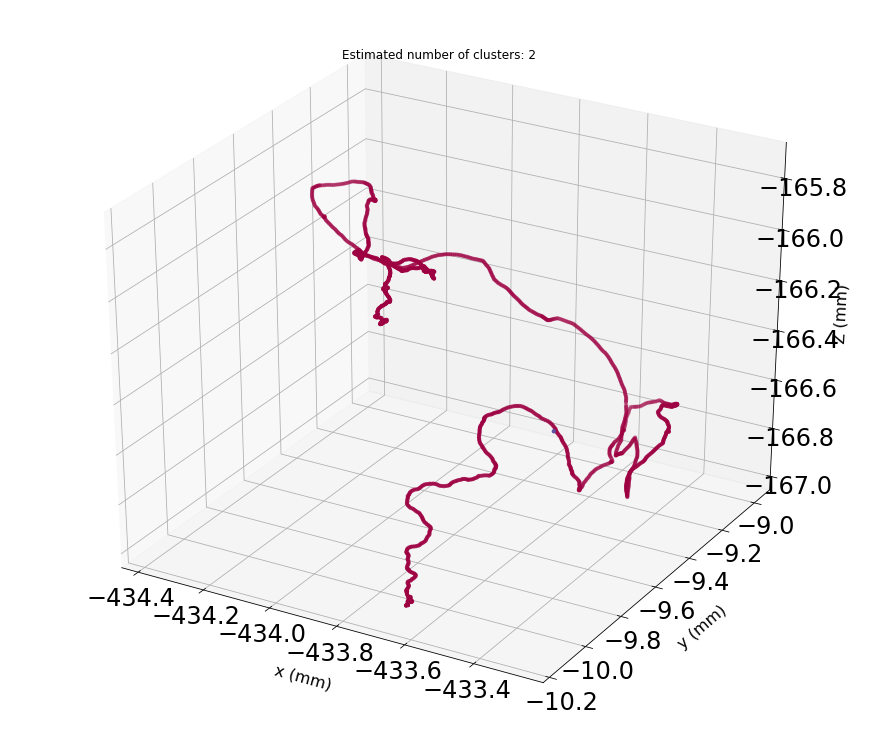

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/therreau/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


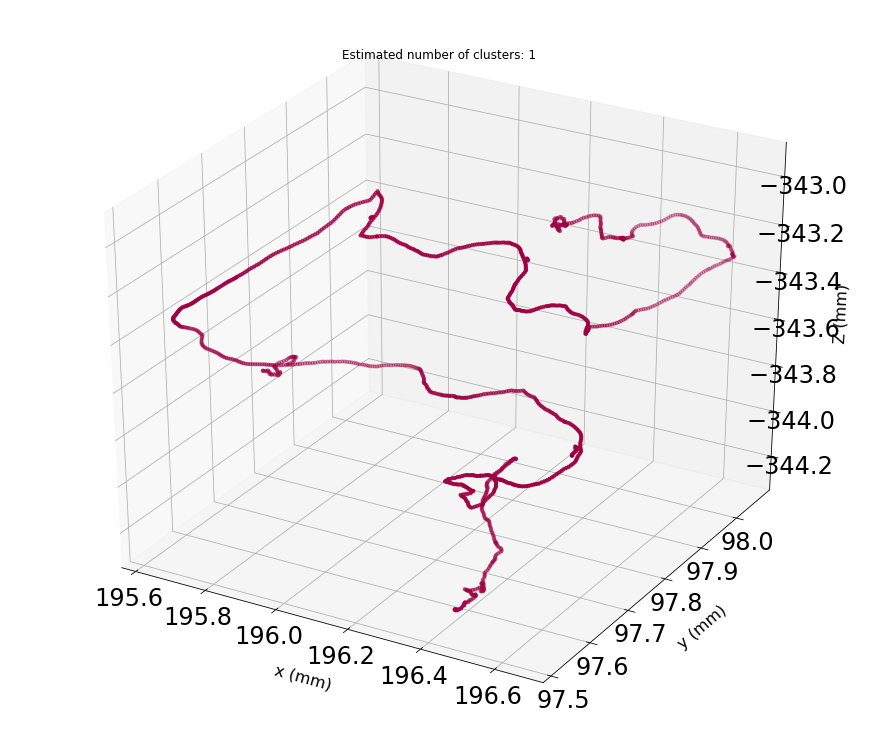

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

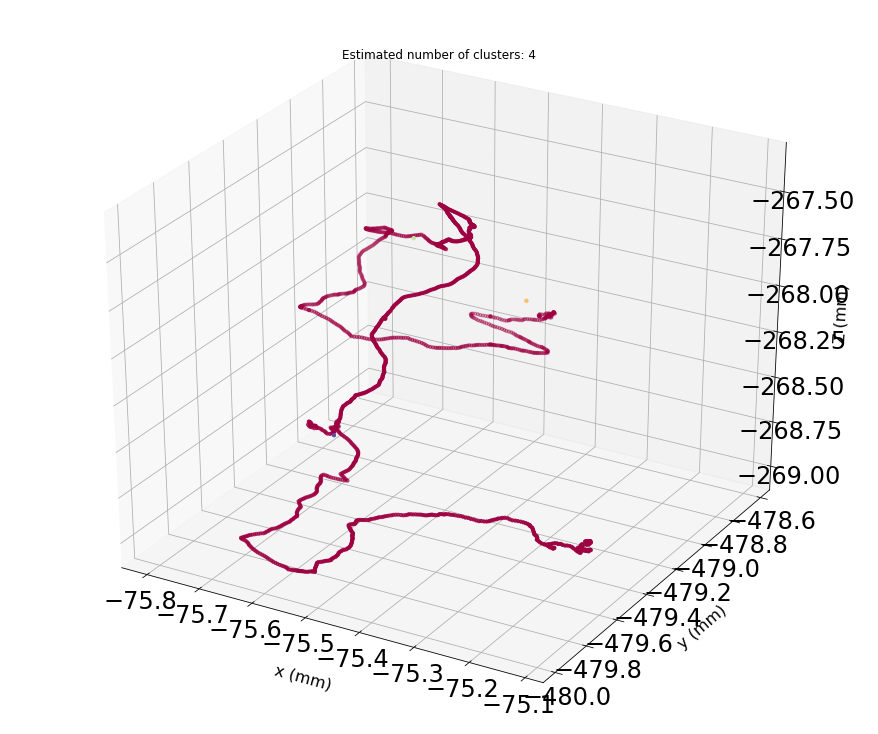

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

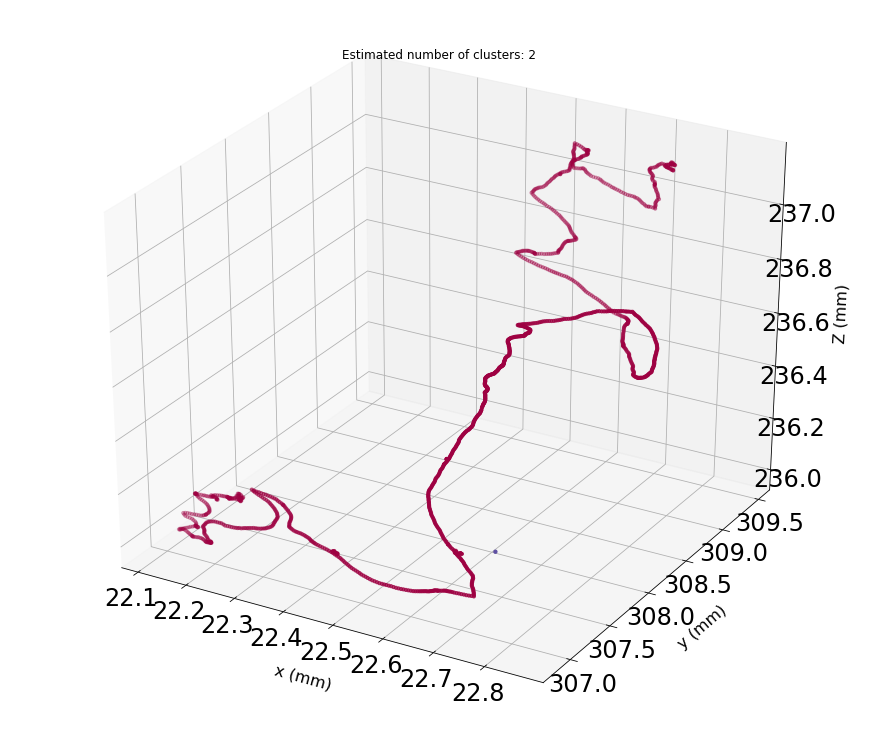

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

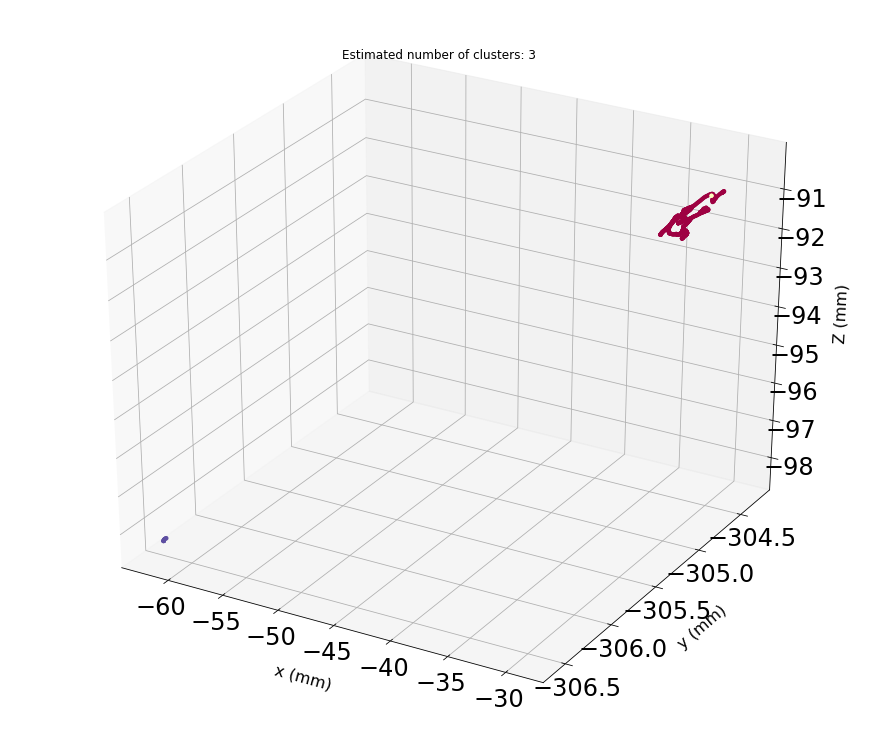

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

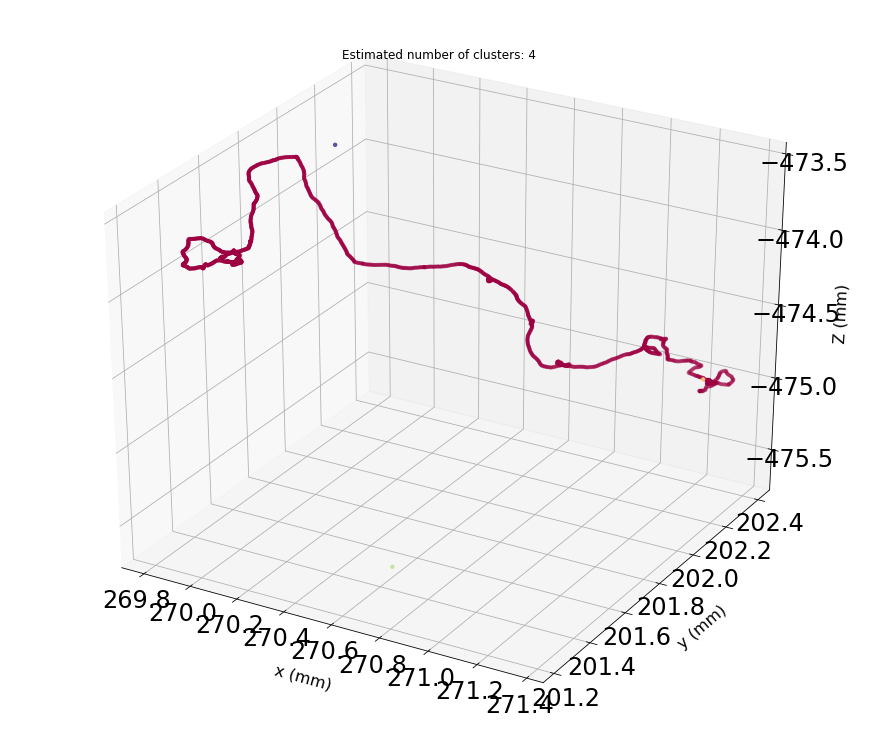

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

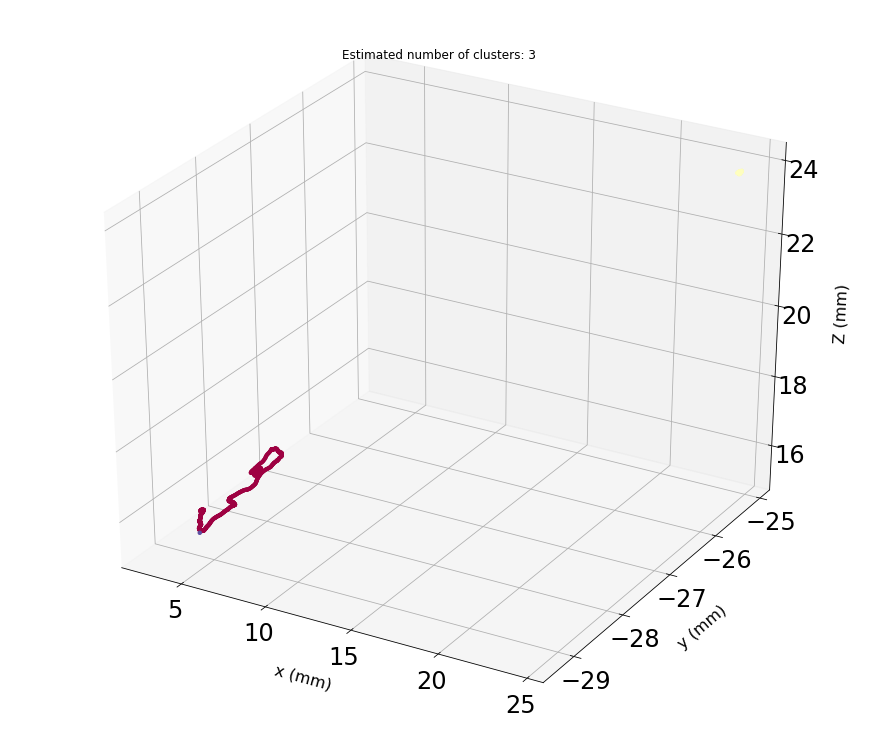

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/therreau/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


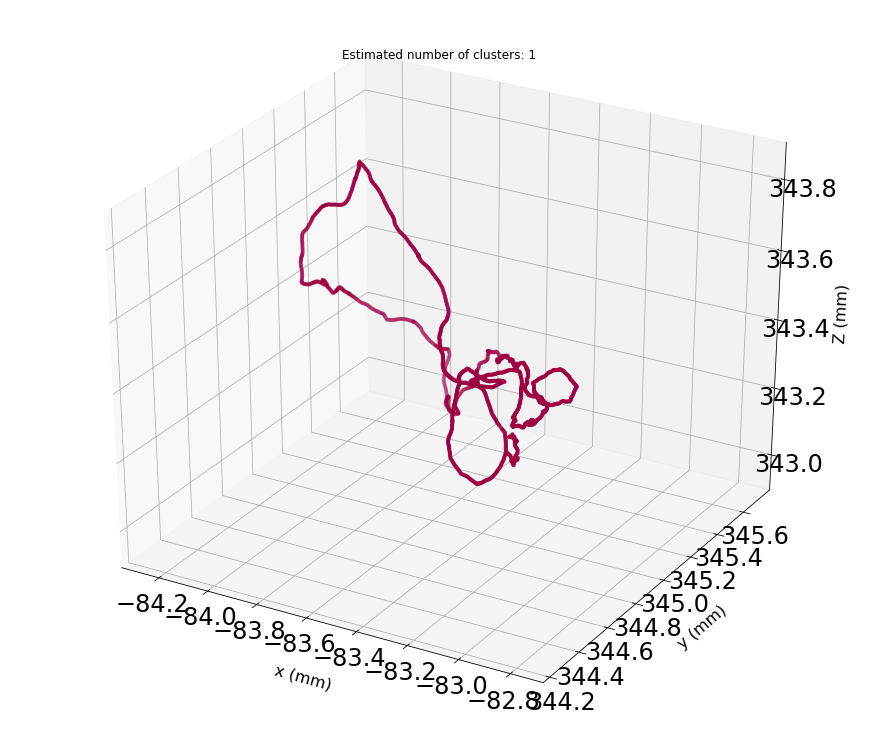

Event 100
...Estimated number of clusters: 4
...Estimated number of noise points: 0
Event 500
...Estimated number of clusters: 8
...Estimated number of noise points: 0
Event 1000
...Estimated number of clusters: 2
...Estimated number of noise points: 0
Event 2000
...Estimated number of clusters: 2
...Estimated number of noise points: 0
Event 3000
...Estimated number of clusters: 2
...Estimated number of noise points: 0
Event 4000
...Estimated number of clusters: 4
...Estimated number of noise points: 0
Event 5000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 6000
...Estimated number of clusters: 3
...Estimated number of noise points: 0
Event 7000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 8000
...Estimated number of clusters: 3
...Estimated number of noise points: 0
Event 9999
...Estimated number of clusters: 3
...Estimated number of noise points: 0


In [68]:
df_cluster= PreClustering(df_0vbb, 
                          "0vbb_PreClustering_plot_10mum",0.01)

In [69]:
df_cluster=move_xyz_to_cm(df_cluster)
df_cluster.to_hdf('0vbb_simulation_pre_clustering_3d.h5', key='df')

/Users/therreau/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['e_cluster_array']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [70]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def ZClustering(test, dir_to_plot,ovbb=True, testing= False):
    
    %mkdir $dir_to_plot
    list_result=[]
    pd.set_option('mode.chained_assignment', None)
    interaction_object=GetInteractionObject('beta')
    print_e=[1,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,1e4,1.5e4,1.6e4,1.9e4]
    colorhere=['b','darkgreen', 'k', 'darkorange','purple','darksalmon', 'royalblue', 
                       'yellow', 'g', 'peru', 'pink','gold']
    for eID in test.event_id.unique():
        event=test[test.event_id==eID]
        
        fig, ax = plt.subplots(1)
        
        # CLUSTERING - Saved ZZ as array
        zz_tot=[]
        for i in range(len(event)):
            zz_tot.append(-event.z_mean.values[i])
            zz_tot.append(1)

        zz_tot= np.asarray(zz_tot).reshape(len(event),2)  

        # Used DB scan : Z clustering as a function of Z 
        def square(z, a,b):
            return np.multiply(0.13313,np.multiply(a,np.sqrt(z)) + b)
       
        if ovbb == True : # 0vbb simulation 1.2 MeV * 2, valeur du pouvoir de separation diff de bg simulation
            a = 0.51
            b = 0.12
        else : # bkg simulation 2.4 MeV 
            print('Z clustering not implement, try again')
            break
            
        if len(event)>=2: # clustering en Z si plus de cluster après pre-clustering 
            # Clusterting value : sp(average(nbZ))
            eps_array =[]
            for i in range(len(event)):
                if -event.z_mean.values[i]<0:
                    eps_array.append(square(event.z_mean.values[i], a,b))
                else :
                    eps_array.append(square(-event.z_mean.values[i], a,b))
            
            eps_clustering = max(eps_array)    
            #eps_clustering = square(-np.average(event.z_mean.values, weights=event.etot.values), 
            #                            a,b) 
            
        else : # si il n'y a qu'un clustering, valeur n'a pas d'importance, seulement pour visulization
            if -event.z_mean.values[0]<0:
                eps_clustering = square(event.z_mean.values[0],a,b) 
            else : 
                eps_clustering = square(-event.z_mean.values[0],a,b) 
            
        ##### Clustering avec DBSCAN ! 
        db = DBSCAN(eps=eps_clustering, min_samples=1).fit(zz_tot)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
       
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        for i in range(len(print_e)):
            if eID==print_e[i]:
                print('Event', eID)
                print('...Estimated number of clusters: %d' % n_clusters_)
                print('...Estimated number of noise points: %d' % n_noise_)

        # Pour verification (testing = True)
        if testing == True :
            print('Event', eID)
            print('...Estimated number of clusters: %d' % n_clusters_)
            print('...Estimated number of noise points: %d' % n_noise_)
            print(eID)
            print(eps_clustering)
        
        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]

        for k, col in zip(unique_labels, colors):
            # k = numéro du macro cluster
            # pour chaque macro cluster, les valeurs de toutes les énergies, nph, ne, 
            # position sont gardés sous forme de array
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k) #point in cluster nb #k

            xy = zz_tot[class_member_mask & core_samples_mask]
            event['cluster_%0.i'%(k)]=(class_member_mask & core_samples_mask)

            e_tot_track=event[event['cluster_%0.i'%(k)]].etot.values
            nph=event[event['cluster_%0.i'%(k)]].nph.values
            nel=event[event['cluster_%0.i'%(k)]].nel.values
            
            deltaxtrack = event[event['cluster_%0.i'%(k)]].delta_x_track.values
            deltaytrack = event[event['cluster_%0.i'%(k)]].delta_y_track.values
            deltaztrack = event[event['cluster_%0.i'%(k)]].delta_z_track.values
          
            x_cluster = event[event['cluster_%0.i'%(k)]].x_mean.values
            y_cluster = event[event['cluster_%0.i'%(k)]].y_mean.values
            z_cluster = event[event['cluster_%0.i'%(k)]].z_mean.values
            
            
            # saving value of cluster numero k
            list_result.append([x_cluster,y_cluster,z_cluster, 
                                deltaxtrack,deltaytrack,deltaztrack,
                                e_tot_track,nph,nel,
                                eID,n_clusters_,k])

            
            #### Showing clustering 
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor='crimson',
                     markeredgecolor='crimson',
                     markersize=15, alpha=0.6)
        
            
            nb_of_point_in_cluster = len(event[event['cluster_%0.i'%(k)]].z_mean.values)
            if len(colorhere)+k < nb_of_point_in_cluster:
                for p in range(nb_of_point_in_cluster):
                    colorhere.append('b')
            
            for l in range(nb_of_point_in_cluster):
                # showing limit of clustering for each points
                z_here = -event[event['cluster_%0.i'%(k)]].z_mean.values[l]
                plt.plot(z_here, 1,color=colorhere[k+l],
                              marker='x', markersize=6)

                rect = [Rectangle((z_here,1),eps_clustering, 1, color = colorhere[k+l]),
                        Rectangle((z_here,1),-eps_clustering, 1, color = colorhere[k+l]),
                        Rectangle((z_here,1),eps_clustering, -1, color = colorhere[k+l]),
                        Rectangle((z_here,1),-eps_clustering, -1, color = colorhere[k+l])]
                pc = PatchCollection(rect, facecolor=colorhere[k+l], alpha=0.2,
                             edgecolor=colorhere[k+l])

                # Add collection to axes
                ax.add_collection(pc)
            plt.xlim(-np.average(event[event['cluster_%0.i'%(k)]].z_mean.values,
                                 weights=event[event['cluster_%0.i'%(k)]]["etot"])-2,
                     -np.average(event[event['cluster_%0.i'%(k)]].z_mean.values,
                                 weights=event[event['cluster_%0.i'%(k)]]["etot"])+2)
            
        plt.xlabel(r'- Z (cm)')
        plt.title('Estimated number of clusters: %d'%(n_clusters_,), fontsize=12)
        plt.ylim(-1,3)
        plt.tight_layout()
        if testing ==False :
            if eID<20:
                plt.savefig(dir_to_plot+'/event_nb_%i.png'%(eID))
                plt.show()
            else :
                plt.close()
        else :
            plt.show()

    # dict with all clusters results saved to datafarm    
    df_cluster_z_clustering =pd.DataFrame(list_result,columns=["x", "y","z", 
                                                               "delta_x_track","delta_y_track","delta_z_track",
                                                               "etot",
                                                               "nph","nel",
                                                               "event_id","nb_cluster", "cluster_id", 
                                                  ])
    return df_cluster_z_clustering

In [71]:
df_cluster = pd.read_hdf('0vbb_simulation_pre_clustering_3d.h5', key='df')

mkdir: 0vbb_ZClustering_plot: File exists


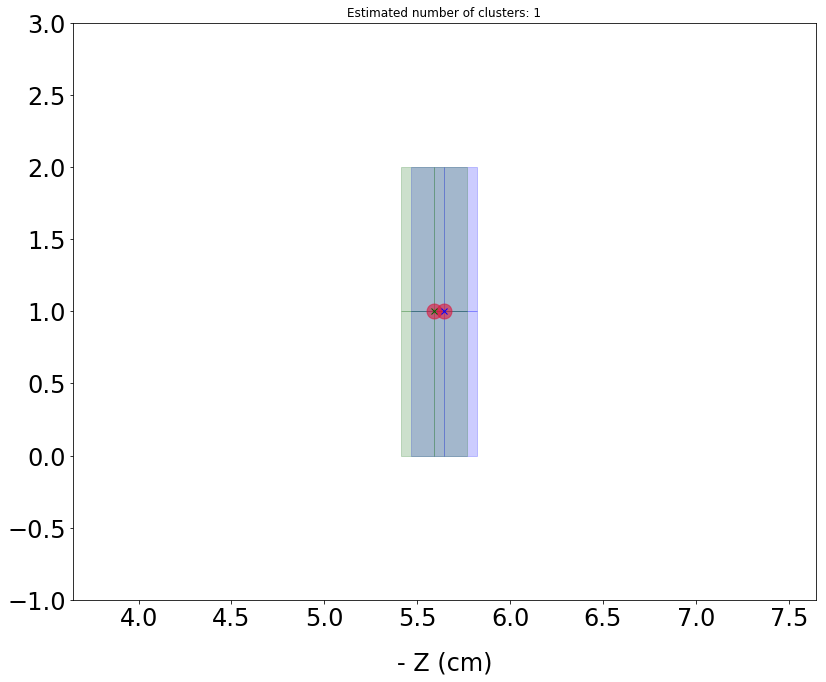

Event 1
...Estimated number of clusters: 2
...Estimated number of noise points: 0


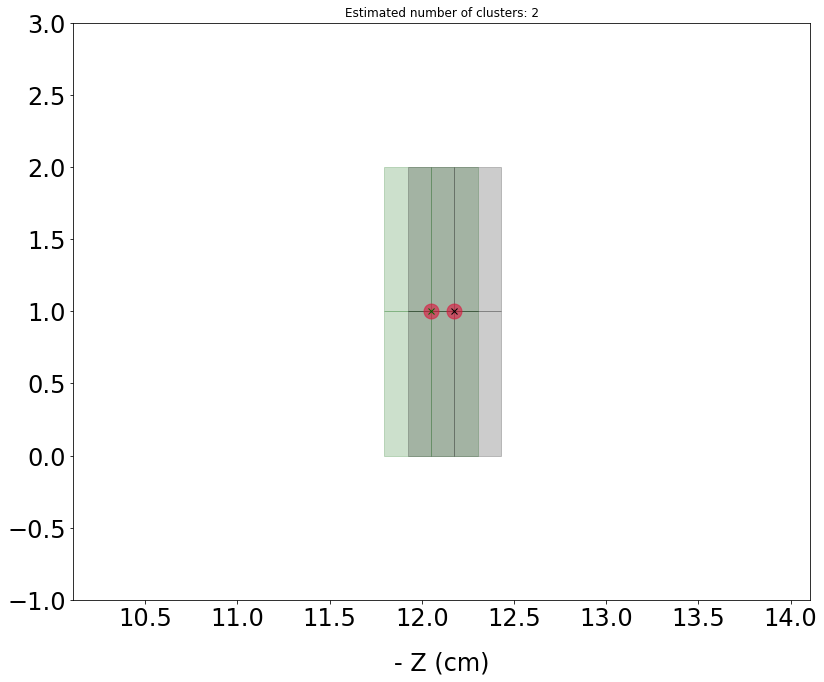

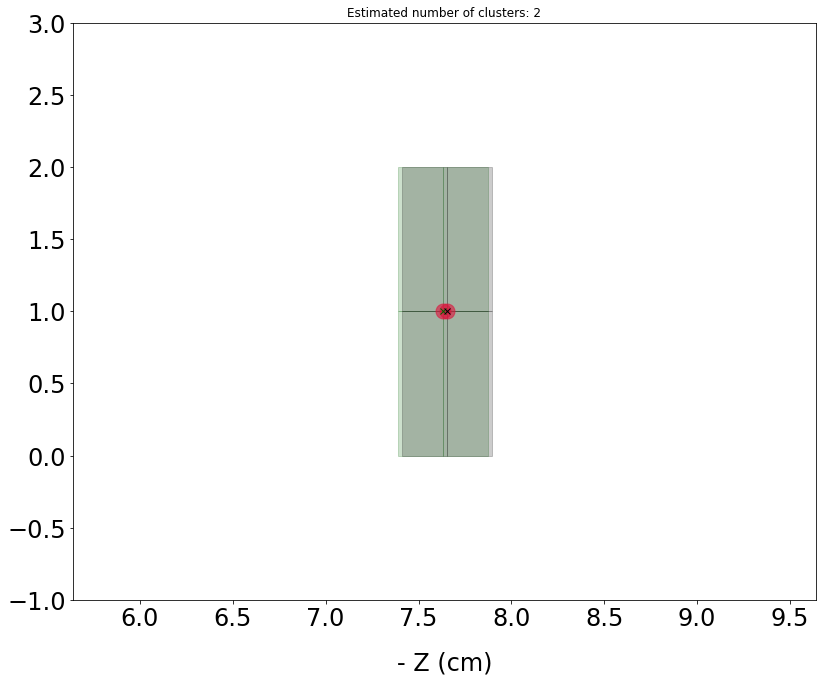

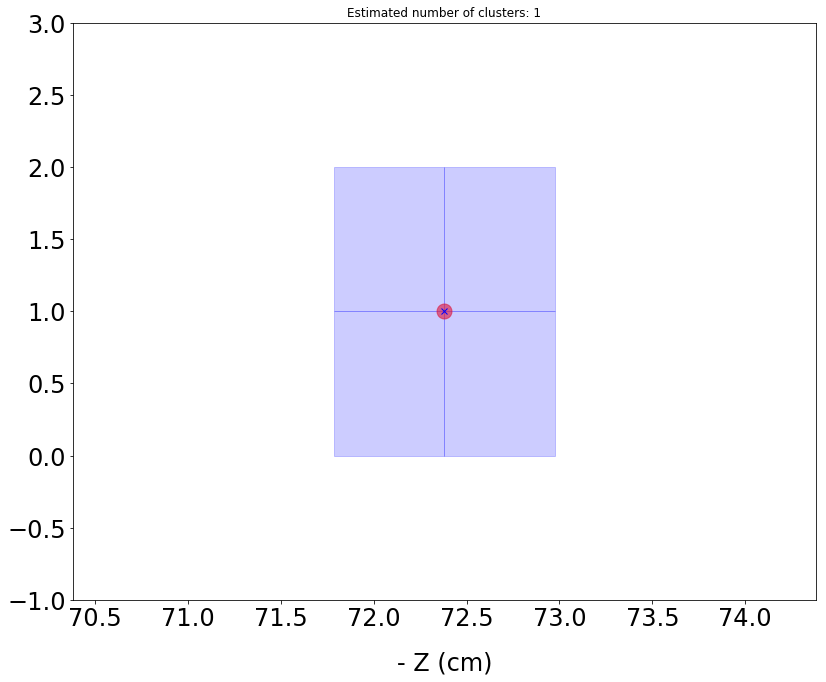

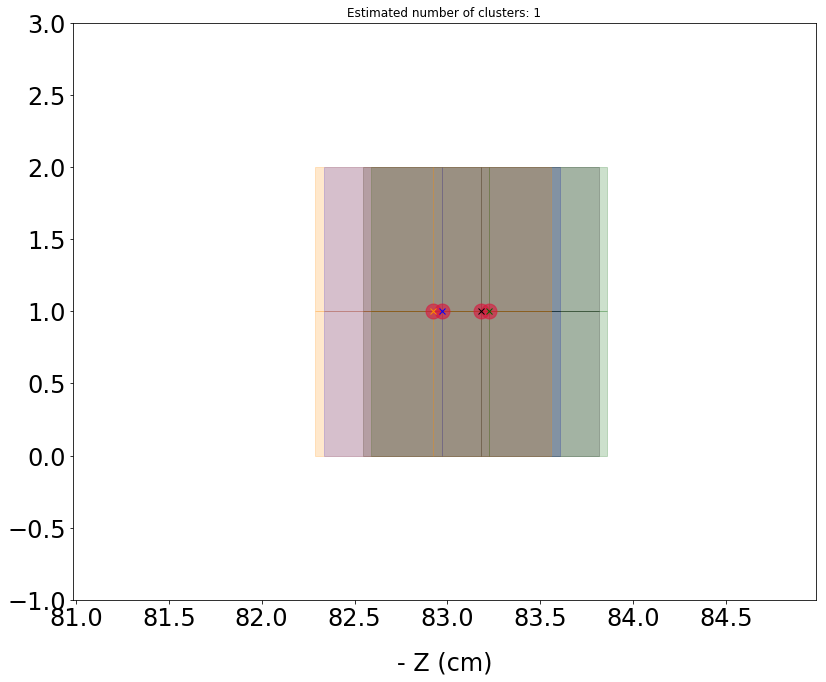

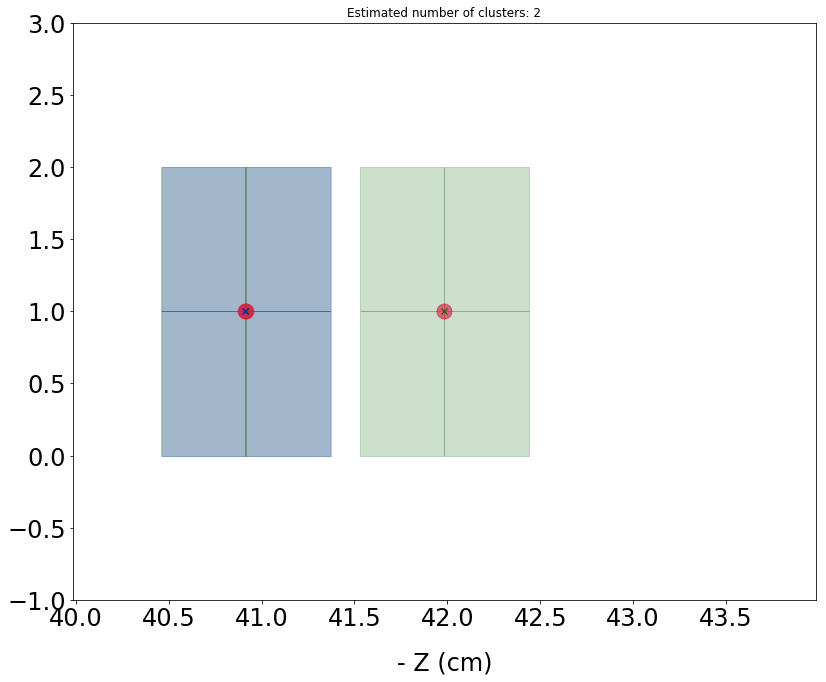

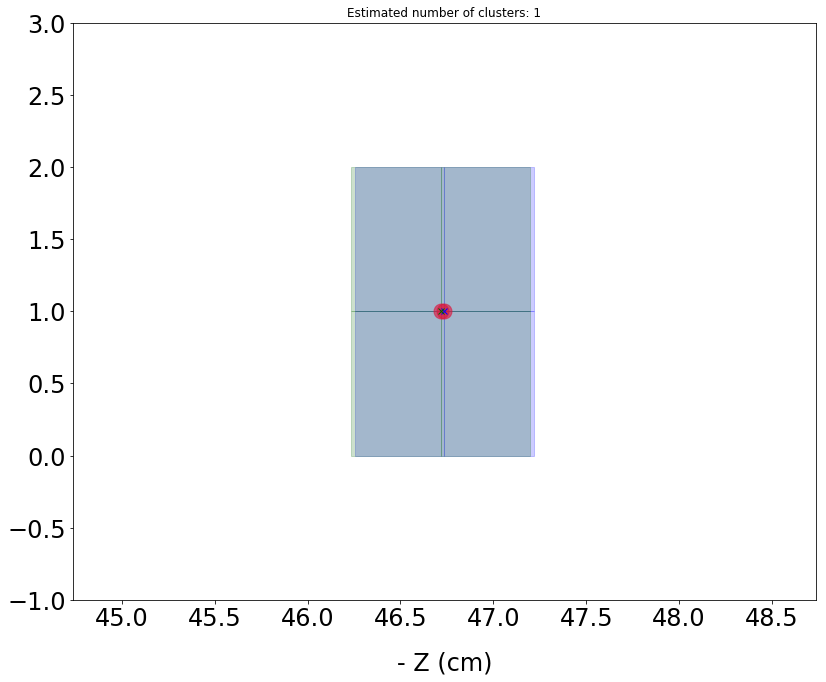

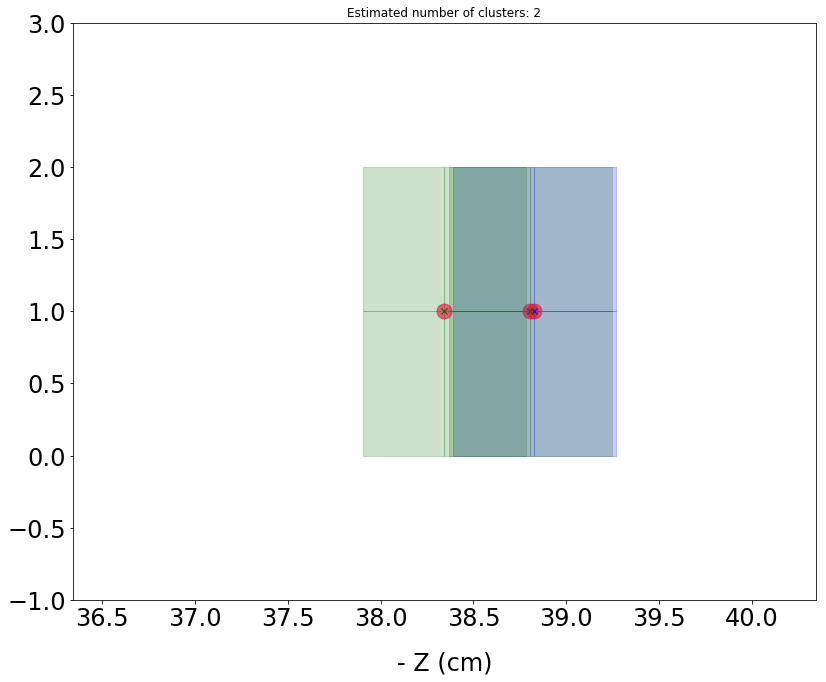

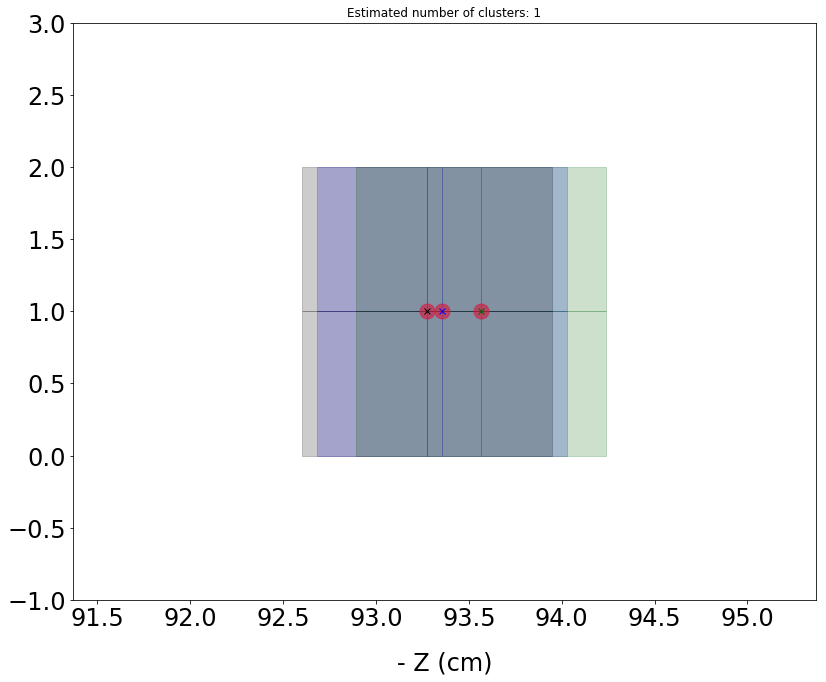

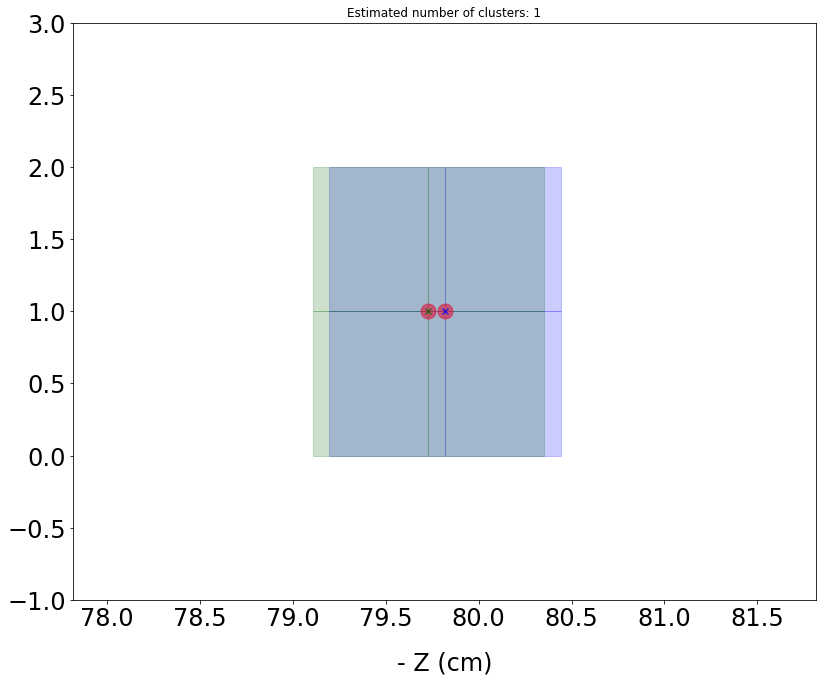

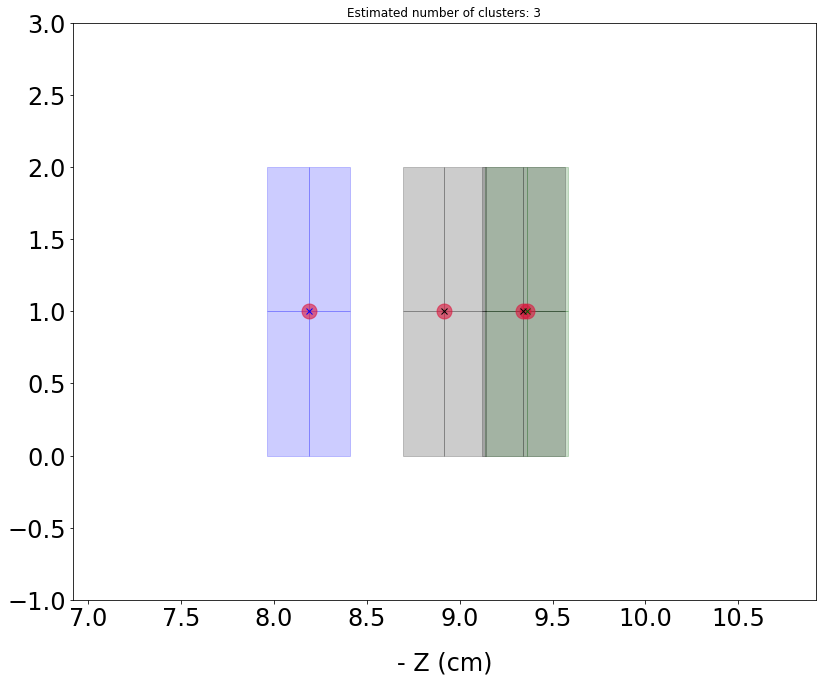

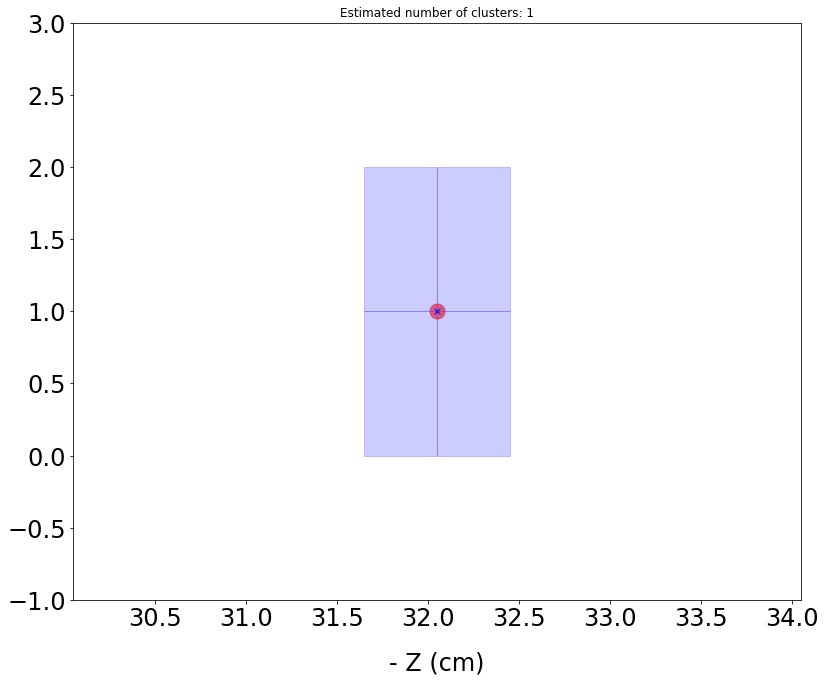

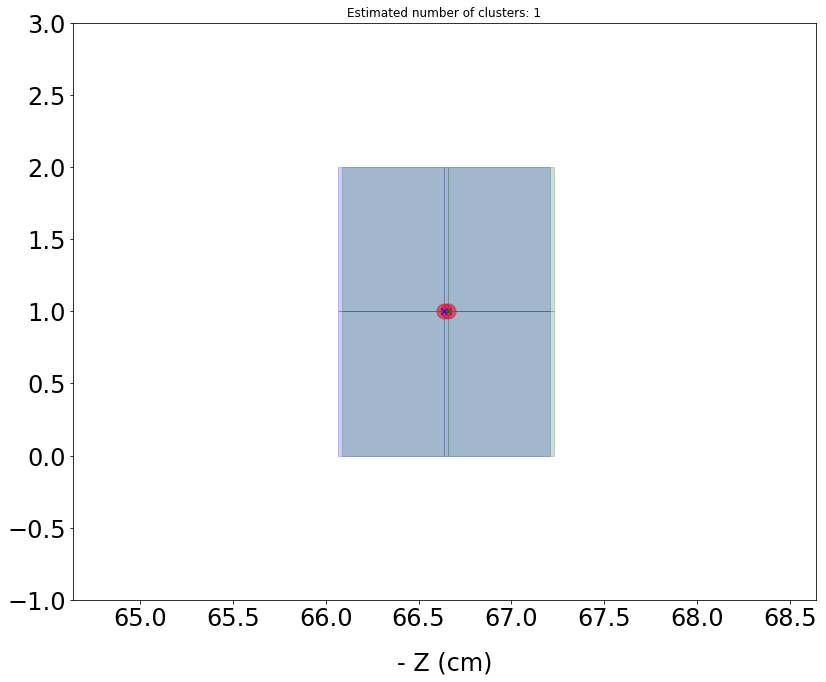

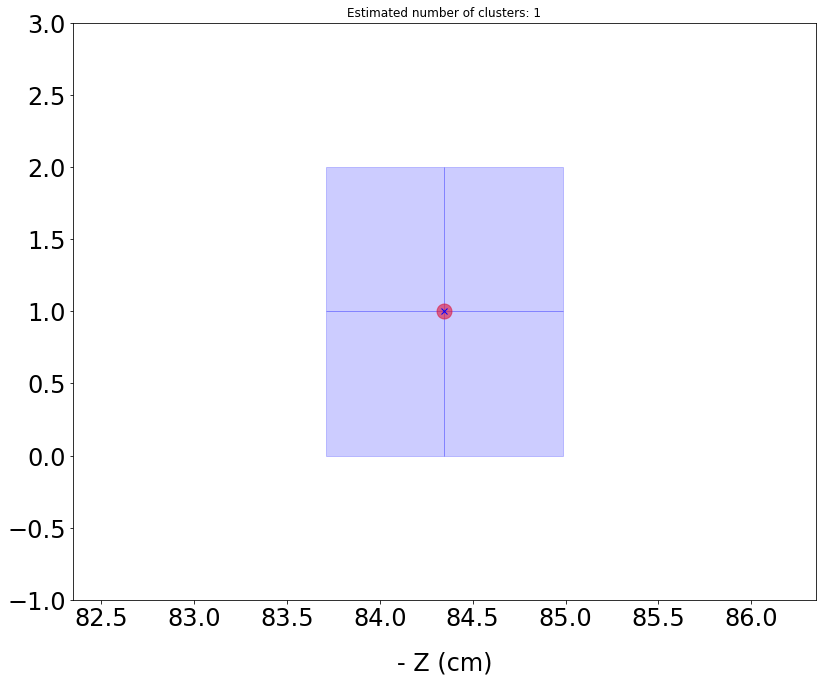

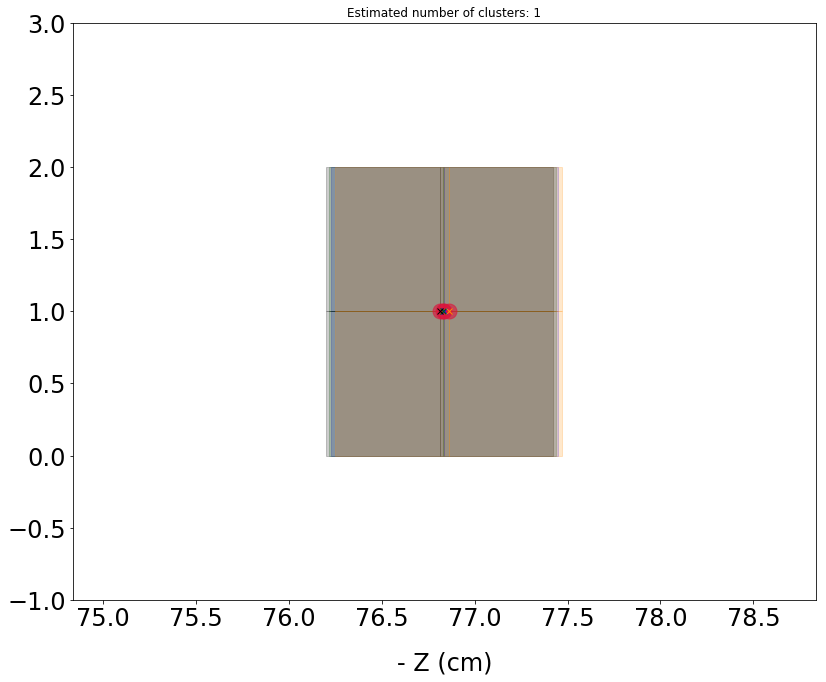

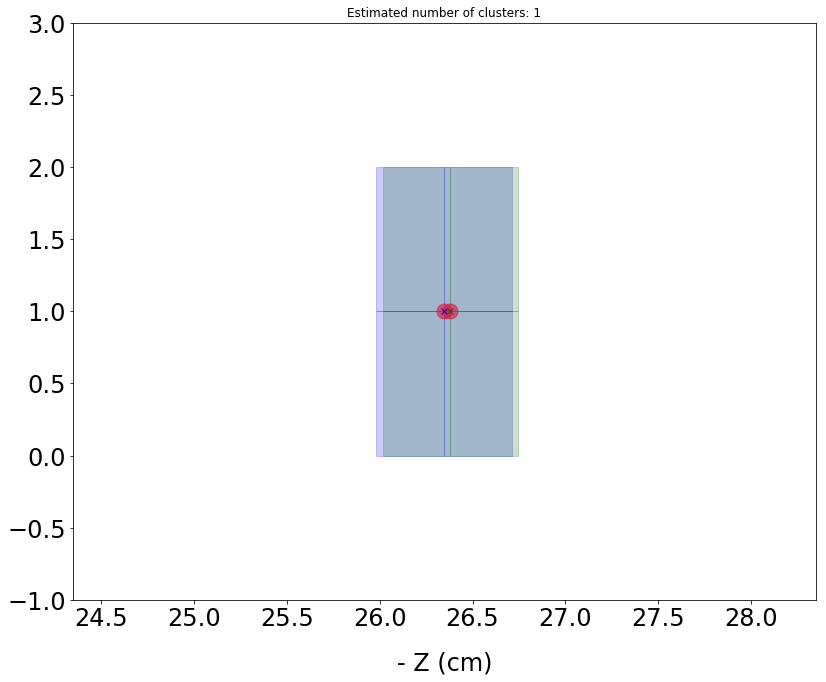

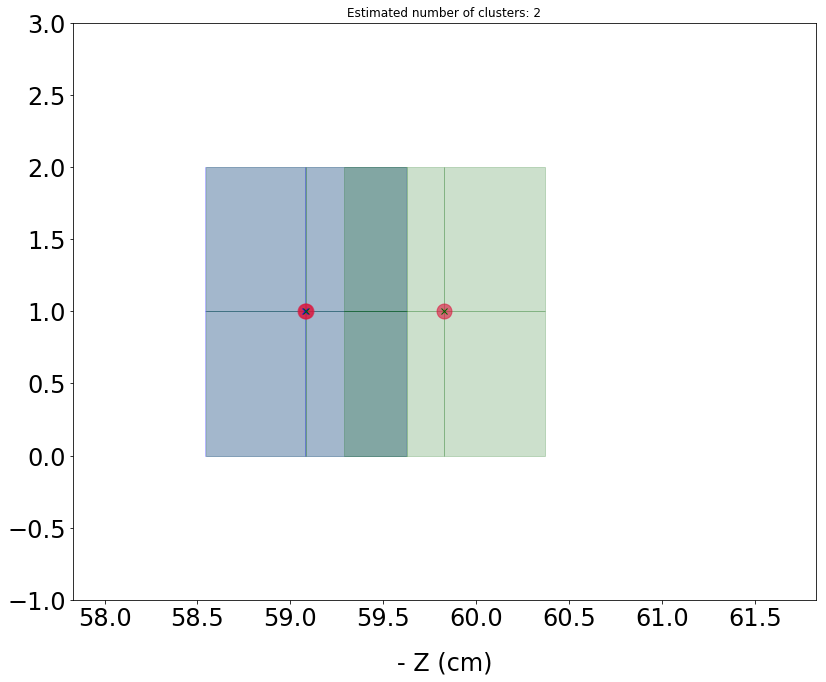

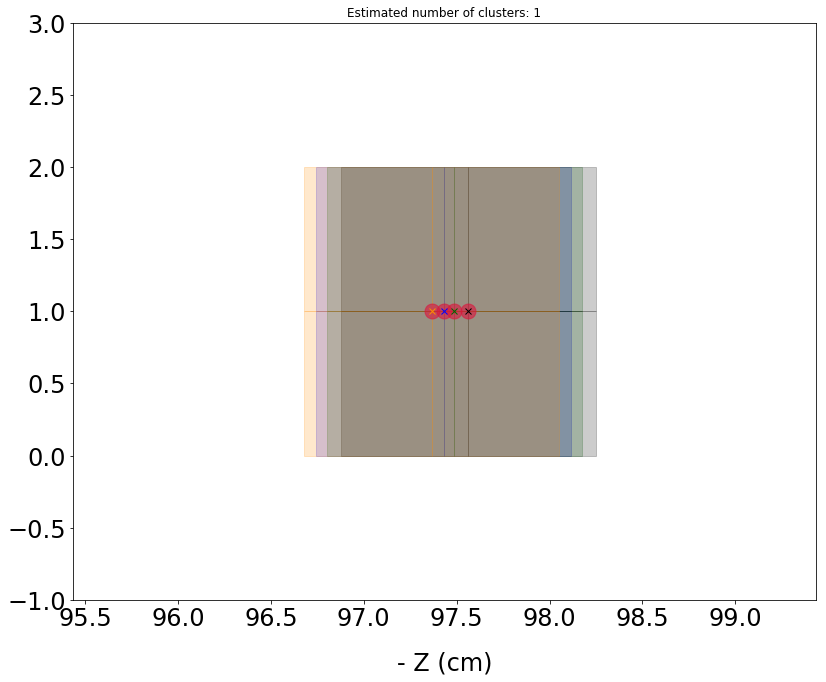

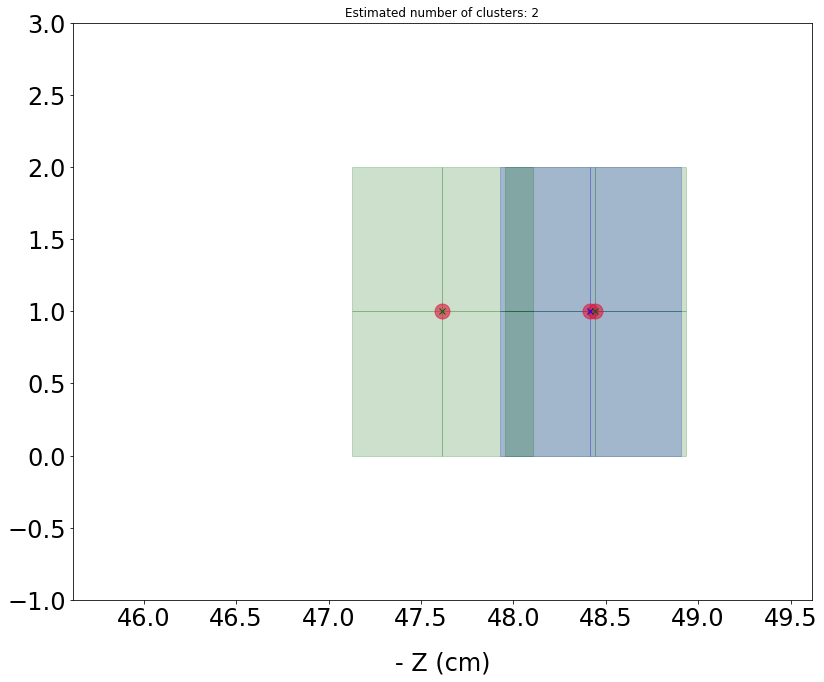

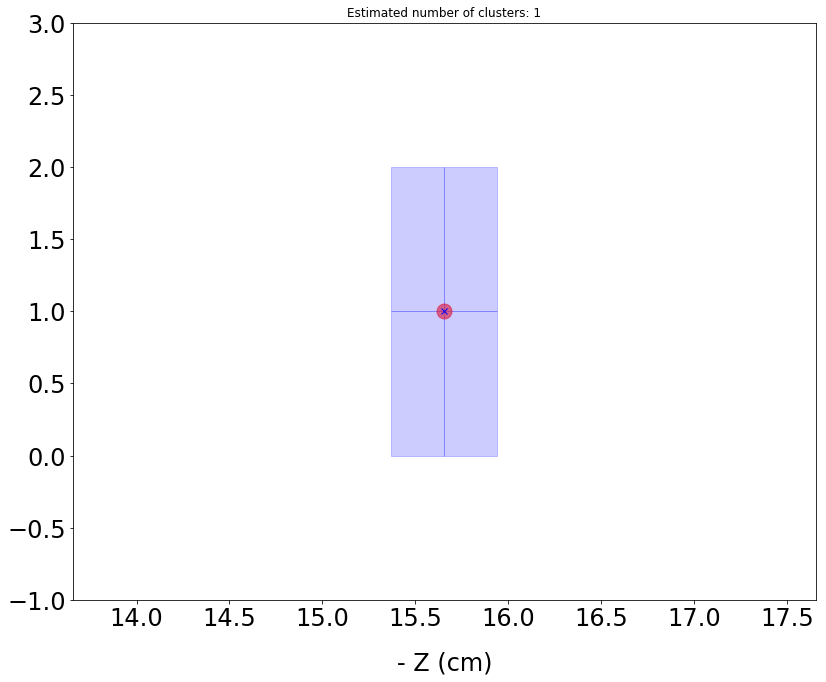

Event 100
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 500
...Estimated number of clusters: 4
...Estimated number of noise points: 0
Event 1000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 2000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 3000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 4000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 5000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 6000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 7000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 8000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 9000
...Estimated number of clusters: 1
...Estimated number of noise points: 0
Event 10000
...Estimated number of clusters: 1
...Estimated number 

In [72]:
df_cluster_z_clustering=ZClustering(df_cluster,"0vbb_ZClustering_plot", ovbb=True, testing=False)

In [76]:
df_cluster_z_clustering.to_hdf('0vbb_simulation_z_clustering_preclust3d.h5', key='df')

In [78]:
len(df_cluster_z_clustering[df_cluster_z_clustering.nb_cluster==1].event_id.unique())/len(df_cluster_z_clustering.event_id.unique())*100

87.225